<a href="https://colab.research.google.com/github/afeinstein20/tasc-tutorial/blob/master/tasc5_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Only necesary when running in Colab
!pip install eleanor
!pip install matplotlib
!pip install bls.py
!pip install stella

In [1]:
import stella
import eleanor
import numpy as np
from bls import BLS
import lightkurve as lk
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.coordinates import SkyCoord
from lightkurve.lightcurve import LightCurve as LC

import warnings
warnings.filterwarnings('ignore')

eleanor.__version__
eleanor.__path__

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['/anaconda3/lib/python3.6/site-packages/eleanor']

# The Goal

![alt text](./figures/ffis.jpg_large "FFIs")
Image Credit: Jonathan Irwin @Mdwarfgeek

We want to create light curves for stars (and other objects!) found within the TESS Full-Frame Images (FFIs). Grabbing pixels and doing a bit of photometry shouldn't be a problem, right? The big issue is that the FFIs for each sector is around 735,000 Mb and it's safe to assume most people don't have access to that kind of computing space.

# Pass in a TIC ID $\rightarrow$ Get a Light Curve!

![alt text](./figures/eleanor.gif "eleanor")

The simplest approach to extracting an $\texttt{eleanor}$ target pixel file (TPF) and light curve is by passing in a $\textit{TESS}$ Input Catalog (TIC) ID.

For this example, we will use TIC 350146296. Calling $\texttt{eleanor.Source()}$ will crossmatch to a $\textit{Gaia}$ ID, coordinates, and which sector(s), camera(s), and CCD(s) the star is present in. 

To start, we know this star was observed in Sector 1, so we will extract the light curve only from this sector.

In [2]:
tic = 234503282
star = eleanor.Source(tic=tic, sector=1, tc=True)

You may notice there is this strange input $\textbf{tc=True}$. Right now, $\texttt{eleanor}$ is interfacing with the tool TESSCut from MAST. The reason for this is because we're still processing our data products ┐(ツ)┌, but wanted to give the community quick access to the data once it's available.

In [3]:
print("TIC ID: ", star.tic)
print("Coordinates: ", star.coords)
print("Camera, CCD Location: ", star.camera, ',', star.chip)
print("TESS Mag: ", star.tess_mag)

TIC ID:  234503282
Coordinates:  [11.5954773617207, -63.4730680663561]
Camera, CCD Location:  3 , 1
TESS Mag:  10.9643


In [16]:
data = eleanor.TargetData(star, do_psf=True, do_pca=True, save_postcard=False)

100%|██████████| 1282/1282 [00:34<00:00, 36.89it/s]


A "postcard" is assigned when calling $\texttt{eleanor.Source()}$, but what exactly is a postcard? A postcard is a 148 $\times$ 104 pixel cutout of the FFIs that are time-stacked and background subtracted. For the postcard background, we subtract a constant from the frame using $\texttt{photutils.MMMBackground()}$. The background at each cadence is passed through with the postcard object. In the future, we will have a 2D modeled background available. (It's being processed for each sector as we speak!)

However, when setting $\textbf{tc = True}$, because we're using TESSCut, the postcard is a 31 $\times$ 31 pixel cutout, the maximum allowed sized from the software.

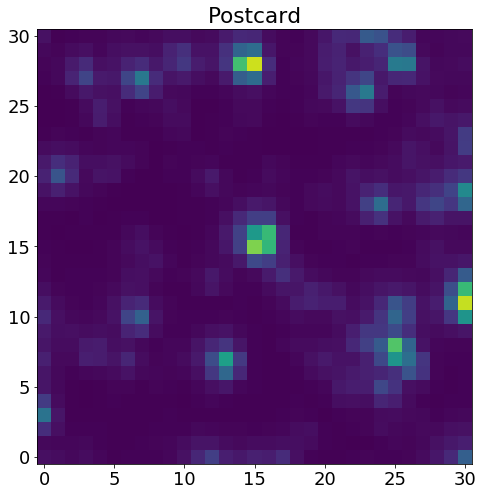

In [17]:
%matplotlib inline
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (14,8)

plt.figure(figsize=(14,8))
plt.imshow(data.post_obj.flux[0], origin='lower', vmax=400)
plt.title("Postcard")
plt.show()

Now that we have our Source information, we simply call the $\texttt{eleanor.TargetData()}$ function, which will extracted a TPF, perform aperture photometry with an automatically optimized aperture choice, and complete some simple systematics corrections.

For first time users, or users looking at this part of the TESS FOV for the first time, a file will download. Don't be alarmed! We promise it's not a virus. The downloading file is the postcard that we just discussed.

If you call $\texttt{do}$_$\texttt{psf=True}$ (which enables you to complete a simple point-spred function model), a loading bar will appear to let you know which cadence the model is on and when. If you do not call do_psf, no loading bar will appear.

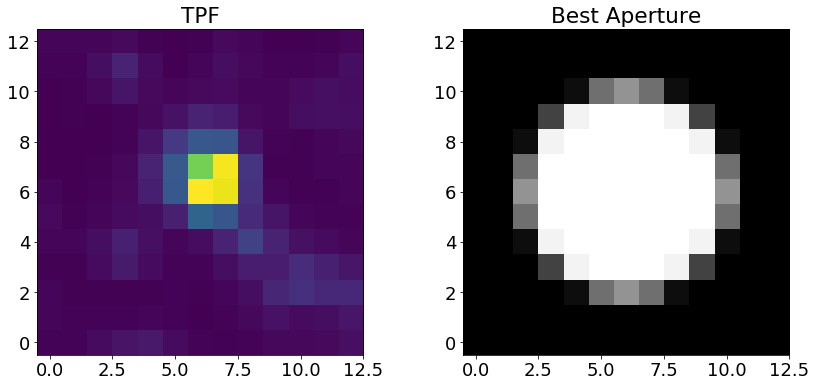

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14,6))
ax1.imshow(data.tpf[0], origin='lower', vmax=300)
ax1.set_title('TPF')
ax2.imshow(data.aperture, origin='lower', cmap='Greys_r')
ax2.set_title('Best Aperture');

At first glance, this aperture may be a little big... But we'll look at that later. First, let's see what the background looks like. There are two steps to the background subtraction: on the postcard level and on the TPF level. We can check how much background was subtracted by calling:

In [19]:
data.bkg_type

'PC_LEVEL'

"PC_LEVEL" means Postcard Level, so no additional background was subtracted at the TPF level, which is probably for the best because this TPF is quite crowded! In the future, we will also have a $\textbf{2D_BKG}$ setting as well, where we find a interpolate on the postcard level.

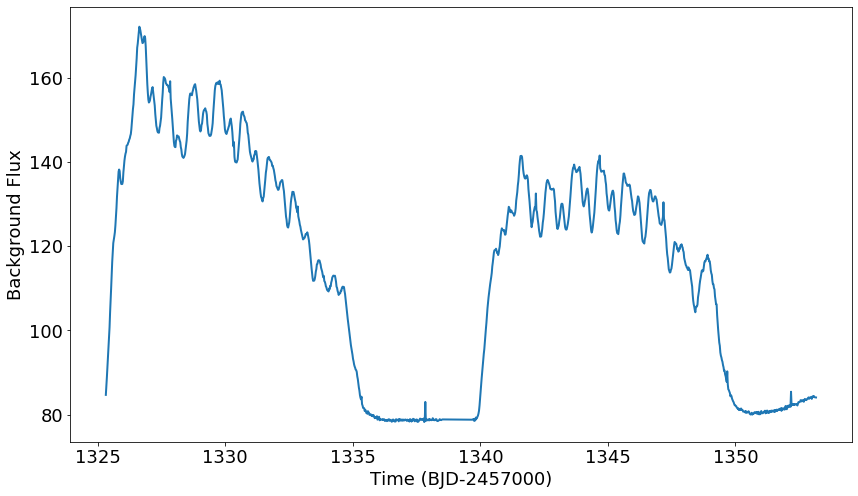

In [20]:
plt.plot(data.time, data.flux_bkg, linewidth=2)
plt.xlabel('Time (BJD-2457000)')
plt.ylabel('Background Flux');

This is pretty close to what we expect for the background, given the scattered light from Earth. We also create Quality Flags for the user. These will alert the user of spacecraft issues, such as thruster fires, where the data at that time may not be good/useful. We can see how many data points are quality flagged:

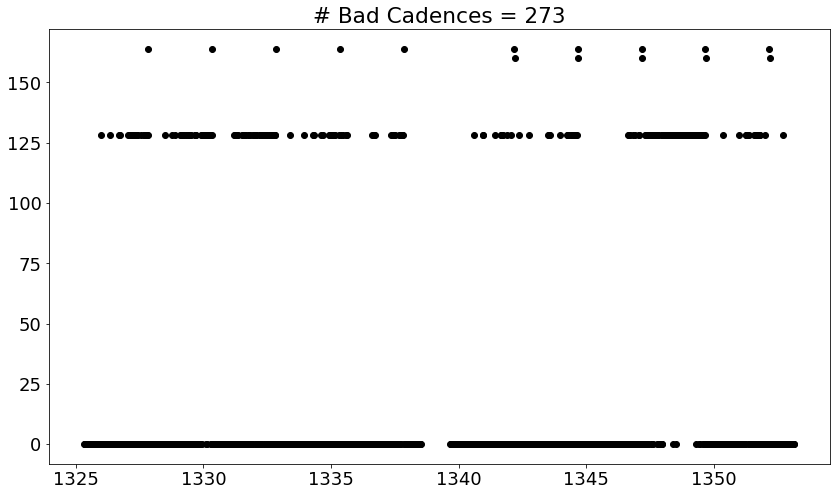

In [21]:
plt.plot(data.time, data.quality, 'ko')
plt.title("# Bad Cadences = {}".format(
            len(np.where(data.quality !=0)[0])));

Any cadence where Quality Flag != 0 is potentially a bad one. I think it's time to plot our first light curve! We're only plotting the cadences with good quality flags. We provide $\textbf{four}$ different light curve options:
    1. Raw Flux -- Just aperture photometry.
    2. Corrected Flux -- Simultaneous regression of the light curve against the inferred background, position, CBVs, and other telescope data.
    3. PCA Flux -- Using the SPOC provided CBVs to remove common systematics in light curves on the same CCD.
    4. PSF Flux -- The point-spread function modeled flux.

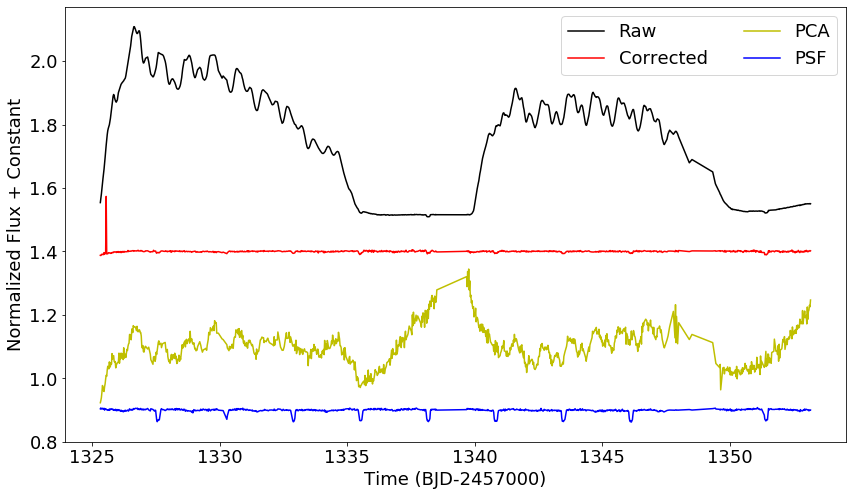

In [30]:
q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.median(data.raw_flux[q]) + 0.8 , 'k', label='Raw')
plt.plot(data.time[q], data.corr_flux[q]/np.median(data.corr_flux[q]) + 0.4, 'r', label='Corrected')
plt.plot(data.time[q], data.pca_flux[q]/np.median(data.pca_flux[q]) + 0.1, 'y', label='PCA')
plt.plot(data.time[q], data.psf_flux[q]/np.median(data.psf_flux[q]) - 0.1, 'b', label='PSF')
plt.legend(ncol=2)
plt.xlabel('Time (BJD-2457000)')
plt.ylabel('Normalized Flux + Constant');

Yay light curves! Yay a signal! What could it be?? First, we should try creating a light curve with a smaller aperture, to make sure there isn't a background source causing this signal. TESS's pixels are large, so this is a good test to do. LUCKILY! Every $\texttt{eleanor.TargetData()}$ object comes equipt with all of the apertures we tested and all of the raw and corrected fluxes for these additional apertures.

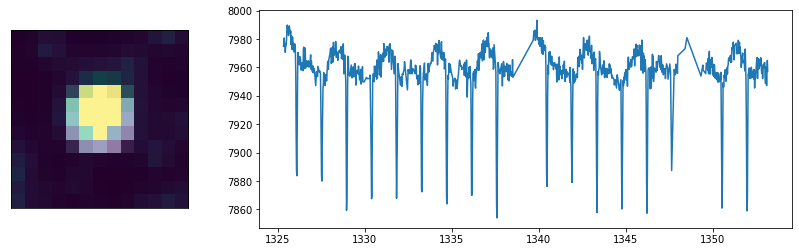

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3], height_ratios=[2]) 
ax0 = plt.subplot(gs[0])
ax0.imshow(data.tpf[0], origin='lower', vmax=300)
ax0.imshow(data.all_apertures[13], origin='lower', cmap='Greys_r', alpha=0.5)
ax0.set_xticks([])
ax0.set_yticks([])
ax1 = plt.subplot(gs[1])
ax1.plot(data.time[q], data.all_corr_lc[13][q])
plt.show()

If the 21 apertures $\texttt{eleanor.TargetData()}$ provides you with isn't enough, or you want to try a different shape or weighting scheme, you can create your own 2D array of the same shape as the TPF and pass that in as an aperture.

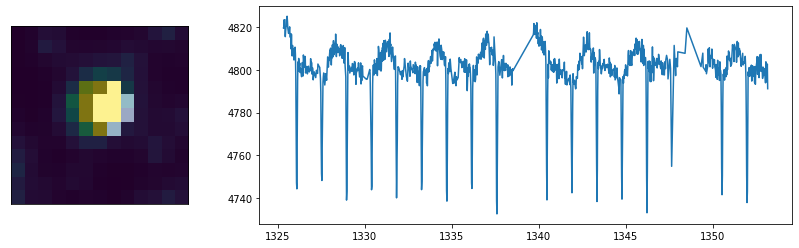

In [12]:
mask = np.zeros(np.shape(data.tpf[0]))
mask[5,7] = 1
mask[6:8,6:9] = 1
mask[8,7] = 1

data.get_lightcurve(aperture=mask)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3], height_ratios=[2]) 
ax0 = plt.subplot(gs[0])
ax0.set_xticks([])
ax0.set_yticks([])
ax0.imshow(data.tpf[0], origin='lower', vmax=300)
ax0.imshow(mask, origin='lower', cmap='Greys_r', alpha=0.5)
ax1 = plt.subplot(gs[1])
ax1.plot(data.time[q], data.corr_flux[q])
plt.show()

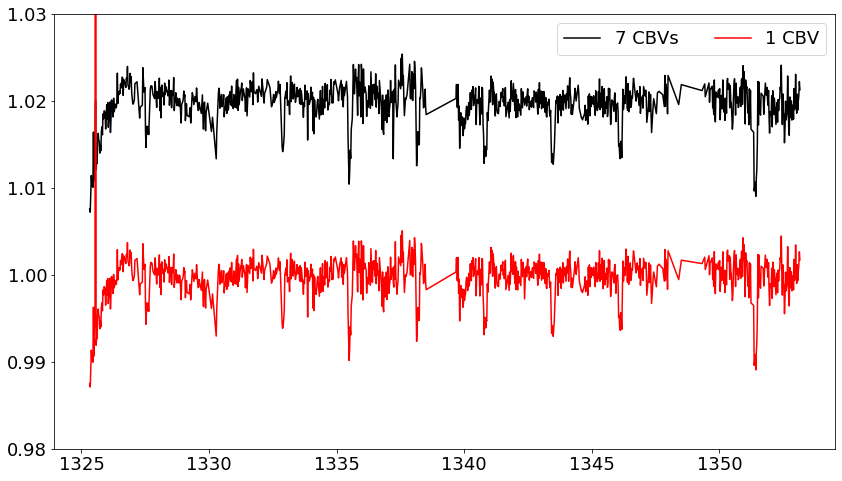

In [34]:
data.pca(flux=data.corr_flux, modes=7)
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q])+0.02, 'k', label='7 CBVs')
data.pca(flux=data.corr_flux, modes=1)
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'r', label='1 CBV')
plt.ylim(0.98,1.03)
plt.legend(ncol=2);

To save your TPF and light curves, it's as easy as

In [14]:
data.save()

Because the $\textit{TESS}$ pixels are so large, sometimes signals can appear that aren't necessarily associated with the star you're looking at. Because of this, we have some investigative tools (and will be implementing more in the future!) to help you figure out if the signal is coming from your star.

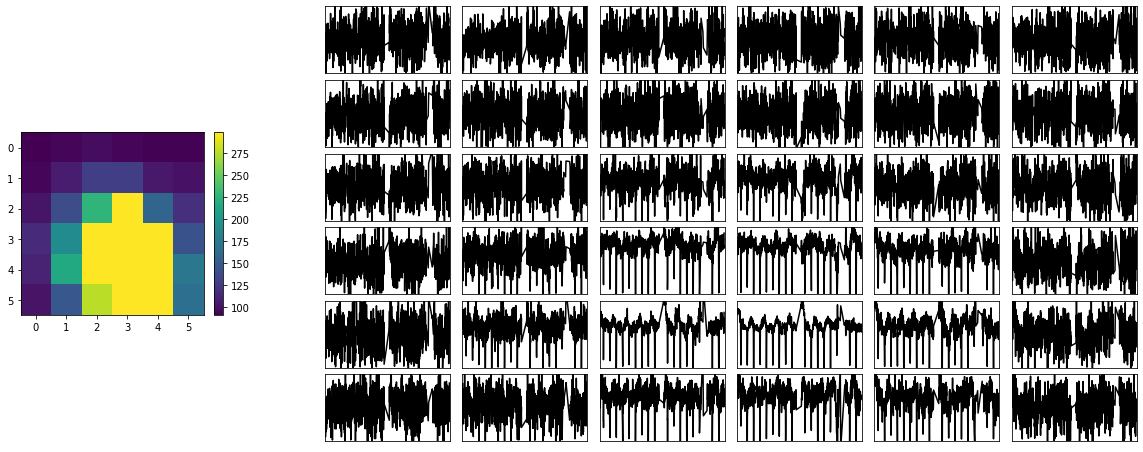

In [9]:
vis = eleanor.Visualize(data)
vis.pixel_by_pixel(rowrange=[3,9], colrange=[3,9])

# Pass in Coordinates $\rightarrow$ Get a Light Curve for Multiple Sectors

Great! Now we know how to create a light curve using $\texttt{eleanor.Source()}$ and $\texttt{eleanor.TargetData()}$ with a TIC ID. Now, let's do it all over again, but this time we'll highlight two additional features:

    1. Pass in coordinates to get a light curve.
    2. Create a light curve for a source observed in multiple sectors.

First, we have to assign our coordinates with a unit. This allows users to pass in coordinates in degrees or hourangle. Then, instead of calling $\texttt{eleanor.Source()}$ as we did last time, we'll call $\texttt{eleanor.multi_sectors()}$, which additionally requires a list of sectors you want. Or, if you simply want all of the available sectors, you set the input $\textbf{sectors = "all"}$. If we call $\texttt{eleanor.Source()}$, it will return the light curve for the most recent sector the target was observed in.

In [15]:
ra  = 95.91767
dec = -75.075775

stars = eleanor.multi_sectors(coords=SkyCoord(ra, dec, unit=(u.deg)), 
                              sectors="all", tc=True)

Found star in Sector(s) 1 2 3 4 5 6 7 8 9 10 11 12
Inflating...
Inflating...
Inflating...
Inflating...
Inflating...
Inflating...
Inflating...
Inflating...
Inflating...
Inflating...
Inflating...
Inflating...


$\texttt{eleanor.multi_sectors()}$ returns a list of $\texttt{eleanor.Source()}$ objects! We can then pass these into $\texttt{eleanor.TargetData()}$ individually to create light curves for each sector.

In [16]:
time = np.array([])
flux = np.array([])

for star in stars:
    datum = eleanor.TargetData(star, save_postcard=False)
    
    q = datum.quality == 0
    
    time = np.append(time, datum.time[q])
    flux = np.append(flux, datum.corr_flux[q]/np.nanmedian(datum.corr_flux[q]))

KeyboardInterrupt: 

In [10]:
plt.figure(figsize=(18,8))
plt.plot(time, flux, 'k')
plt.xlabel('Time (BJD-2457000)')
plt.ylabel('Normalized Flux')
plt.ylim(0.98, 1.1)
plt.xlim(1325,1650);

NameError: name 'time' is not defined

# Let's find some flares

In [ ]:
ys = stella.YoungStars(time=time, flux=flux)

In [ ]:
ys.savitsky_golay()
ys.identify_flares()

In [ ]:
ys.flares

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(ys.time, ys.norm_flux, 'k')
plt.xlim(1396,1407)
plt.ylim(0.98,1.03)
for i,p in ys.flares.iterrows():
    plt.plot(ys.time[p.istart:p.istop+1], ys.norm_flux[p.istart:p.istop+1], '*',
             ms=10, c='red')
    
plt.show()

# Let's fit a transit

In [11]:
def bls_fitting(t, lc):  
    # Make a lightkurve LightCurve object. This will allow us to easily flatten our light curve.
    lk = LC(time=t, flux=lc)
    lc_filt = lk.flatten(window_length=51).flux


    # Create BLS Object:
    #     BLS will fit an array of transit duration times.
    #     You also can pass in a minimum and maximum period, given in days.
    durations = np.linspace(0.05, 0.2, 10)
    model     = BLS(t, lc_filt)
    results   = model.autopower(durations, frequency_factor=5.0,
                                maximum_period=15)
    
    # Find the period and duration from the maximum power peak
    period = results.period[np.argmax(results.power)]
    dur = results.duration[np.argmax(results.power)]
    
    # Find the transit time
    t0 = results.transit_time[np.argmax(results.power)]
    
    # Fold the light curve over the transit time
    t_fold = (t - t0 + 0.5*period) % period - 0.5*period
    
    # EVERYTHING BEYOND HERE IN THE FUNCTION IS FOR PLOTTING PURPOSES
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=1,nrows=3, figsize=(16,11))

    ax2.axvline(period, color='goldenrod', alpha=0.4, lw=5)
    for n in range(2, 10):
        ax2.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
        ax2.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")

    ax2.plot(results.period, results.power, "k", lw=1)

    ax2.set_xlim(np.min(results.period), np.max(results.period))
    ax2.set_xlabel("period [days]")
    ax2.set_ylabel("log likelihood")

    ymin = np.percentile(lc_filt, 1)-0.01
    ymax = np.percentile(lc_filt, 95)+0.01
    
    ax1.plot(t, lc_filt, '.', color="midnightblue")
    ax1.set_ylim(ymin, ymax)

    ax3.plot(t_fold, lc_filt, 'k.')
    ax3.set_xlim(-4*dur, 4*dur)
    ax3.set_ylim(ymin, ymax)
    plt.show()
    
    return period, t0, t_fold, lc_filt

In [13]:
star = eleanor.Source(tic=350930938, tc=True, sector=1)
data = eleanor.TargetData(star, do_pca=True, save_postcard=False)

Inflating...


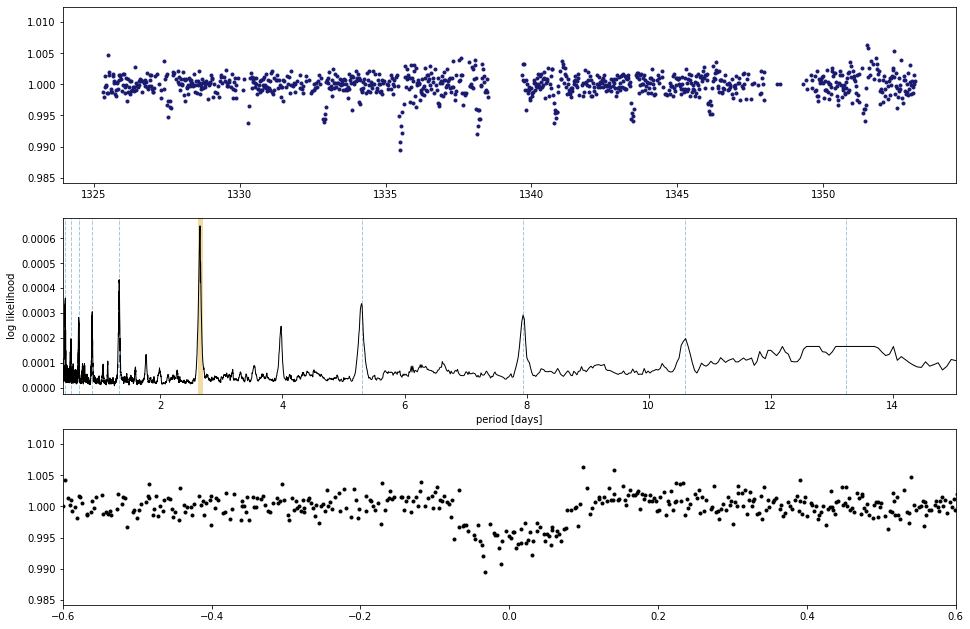

In [14]:
q = data.quality == 0
period_guess, t0_guess, x_fold, y = bls_fitting(data.time[q], data.corr_flux[q])
x = data.time[q]

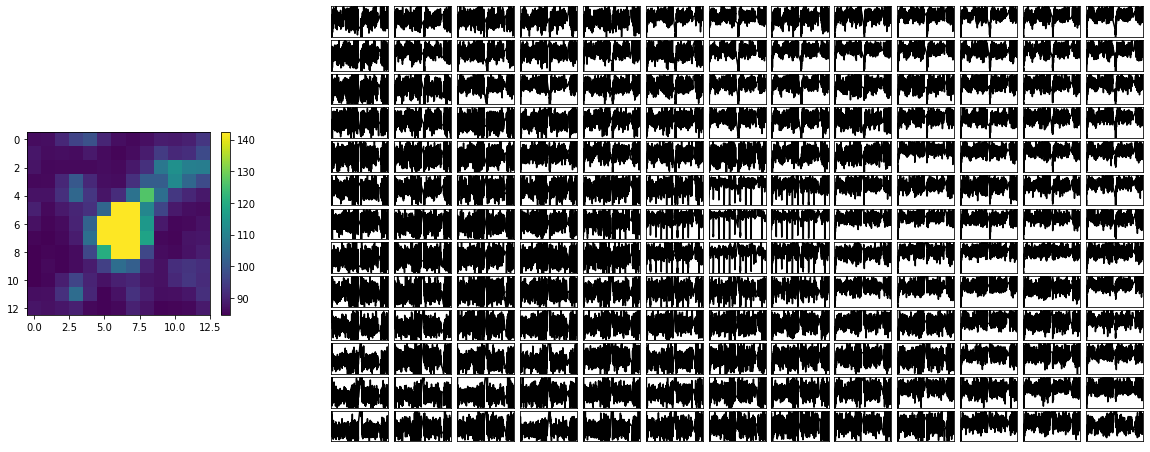

In [15]:
vis = eleanor.Visualize(data)
vis.pixel_by_pixel()

# The $\texttt{eleanor}$ team
<img src="./figures/da_squad.jpg" alt="Team" style="width: 400px;"/>

# Potentially Useful Links

[eleanor Github](https://github.com/afeinstein20/eleanor) /
[stella Github](https://github.com/afeinstein20/stella)

[eleanor Documentation](https://adina.feinste.in/eleanor)

[eleanor Paper arXiv Link](https://arxiv.org/abs/1903.09152)

# Now you try!

TIC 139771134

Gaia 6582115549524788480 (Hint: You do not need to look up the associated TIC ID or coordinates for this source.)

RA, Dec = 04:35:54.594, -66.133666

TIC 260304296

RA, Dec = 113.593357, -64.936218

Guiding questions:

    1. Which have been observed in both Sectors 1 & 2?
    2. Which have potential new planet candidate transits?
    3. Which option of flux gives the clearest signal of a transit?
    
Currently, all sectors are available with TESSCut and $\texttt{eleanor}$. We're working on shipping over the final $\texttt{eleanor}$ postcards to MAST over the next few weeks and then we'll being processing our TPFs and light curves!